# Time-On-Site Prediction Model
The purpose of the TOS Prediction Model is to estimate the amount of time the driver will stay on site.

## Model Preperation Recepie
The data for the model is spread acros the Tasks, WayPoints, task_inventories and inventory_categories tables in the Replica DB PG database. 

## The steps for creating the model
- As there are multiple inventory items per task we need to pick the one that is most relevant.
- Most deliveries (~80%) include one good dropoff and one or two recycling items. We will start with those

### Inputs:
There are two types of possible inputs:
- One is before the optimization when the team, driver, time, sequence are not know. 
- Second is after the optimzation when we know most of the factors that will effect the TOS.

Inputs (partial list):

1. Inventory categroy
2. Inventory time on site - accomulated time on site of
3. Bringg evaluation of the time on site - that is a function on the inventory time on site
After the optimization there is also:
4. Team 
5. Driver
6. Hour in the day
7. Location in the sequence

Note that I am using the Inventory Category and not the item it self as there is not enough data points.


In [1]:
import pandas as pd
import numpy as np
import plotly 
import plotly.plotly as plt
import plotly.graph_objs as go
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Helper functions
def get_sec_m_h(time_str):
    h, m, s = time_str.split(':')
    h, m, s = int(h), int(m), int(s)
    return (h * 3600 + m * 60 + s, h * 24 + m, h) 

def getInventoryType(invList):
    exclusionList = [ 64.0, 58.0]
    length = len(invList)
    for i in range(length):
        if (invList[i] not in exclusionList or i == length - 1) and not invList[i] is None:
            return invList[i]
    return -1.0

def getMSE(series1, series2):
    if len(series2) != len(series1):
        print('Series length should be equal')
    return round(sum((t-p) ** 2 for t,p in zip(series1, series2))/len(series2))

In [3]:
csv_results = 'https://prod-eu1-redash.bringg.com/api/queries/413/results.csv?api_key=8PwUxOmyYdXPQNixs7M2QzzU4SRvGoKHSrfUlCcO'
df_raw = pd.read_csv(csv_results)

print('Initial Length: ' + str(len(df_raw)))



Initial Length: 68257


In [4]:
df_raw[df_raw.isna().cat_id==True]

,task_id,run_id,driver,team_id,t_date,act_order,opt_order,opt_in,act_in,opt_out,act_out,lat,lng,bringg_etos,tos,inventory_name,inventory_etos,cat_id,order_late
0,3040439,42626.0,371.0,20,2018-12-21,1,1,08:26:00,08:38:34,08:51:00,08:41:26,50.614661,3.001757,25,2.864949,SAV D�pose de pr�t SAV pour Solvarea BOULANGER,NaN,NaN,False
1,3040440,42626.0,371.0,20,2018-12-21,2,2,08:59:00,09:06:41,09:49:00,09:11:45,50.632220,3.069406,50,5.080749,BDOM TV Samsung Smart-Interaction 1h L BDOM,NaN,NaN,False
35,3125533,43390.0,371.0,20,2018-12-28,16,10,13:09:00,13:28:25,13:34:00,13:47:46,50.690163,2.647539,25,19.341871,Hors gamme IMAGE BOULANGER,NaN,NaN,False
63,2739304,39019.0,373.0,20,2018-12-03,20,12,13:57:00,13:41:49,14:47:00,14:40:50,50.635202,2.938424,50,59.020203,BDOM TV Samsung Smart-Interaction 1h L BDOM,NaN,NaN,False
71,2907563,40882.0,373.0,20,2018-12-13,5,2,08:54:00,08:55:33,09:39:00,09:05:27,50.630975,3.013638,45,9.899628,Forfait Livraison <300 EUR BOULANGER,NaN,NaN,False
77,2907571,40882.0,373.0,20,2018-12-13,11,3,09:41:00,09:10:12,10:51:00,09:45:22,50.632192,3.003883,70,35.159492,Combi Int�g SAMSUNG BRB260034WW SAMSUNG,NaN,NaN,False
88,2907564,40882.0,373.0,20,2018-12-13,22,10,14:41:00,11:08:27,15:16:00,11:30:26,50.570063,2.945645,35,21.985150,Forfait Livraison <300 EUR BOULANGER,NaN,NaN,False
105,2924717,41173.0,373.0,20,2018-12-14,10,3,09:45:00,10:06:02,10:10:00,10:06:28,50.649606,3.040084,25,0.438987,Combi Int�g ESSENTIELB ERCI 273 ESSENTIELB,NaN,NaN,False
124,2924678,41173.0,373.0,20,2018-12-14,29,10,13:41:00,13:48:33,14:16:00,14:02:26,50.609089,2.983105,35,13.887740,Forfait Livraison <300 EUR BOULANGER,NaN,NaN,False
179,2998898,42147.0,373.0,20,2018-12-19,13,5,10:16:00,10:19:01,11:06:00,10:43:59,50.674085,3.047860,50,24.964639,BDOM TV Samsung Smart-Interaction 1h L BDOM,NaN,NaN,False


In [5]:
groups = df_raw.groupby('task_id')
df_tasks = pd.DataFrame({'inv_count': groups.size(), 'run_id': groups.run_id.mean(),'opt_order':groups.opt_order.max(), 'driver': groups.driver.max(),
                         'team': groups.team_id.min(), 'inventory_etos': groups.inventory_etos.max(),
                         'tos': groups.tos.mean(), 'calc_tos': groups.bringg_etos.mean(),
                       'opt_in': groups.opt_in.min(), 'opt_out':groups.opt_out.max(),
                       'act_in': groups.act_in.min(), 'act_out':groups.act_out.max(),
                         'cat_1':groups.cat_id.max(),'cat_2':groups.cat_id.min(), 'is_late': groups.order_late.max(),
                         'cat_3':groups.cat_id.median(), 'name':groups.inventory_name.min()
                      })

In [6]:
print('Initial number of tasks: ' + str(len(df_tasks)))
# Now we will work on the ~80% of the data where there is one item to deliver.
df = pd.DataFrame(df_tasks)

Initial number of tasks: 26509


In [7]:
total_shipments = len(df)

df.loc[(df['inv_count'] == 1), 'type'] = 1
df.loc[(round(df['cat_1']) == 64.0) & (df['inv_count'] == 2), 'type'] = 2
df.loc[(round(df['cat_1']) == 64.0) & (round(df['cat_3']) == 58.0) & (df['inv_count'] == 3), 'type'] = 3

df['inv_dropoff'] = df.apply(lambda row: getInventoryType([row.cat_1, row.cat_2, row.cat_3]), axis=1)
df['inv_dropoff'] = df['inv_dropoff'].astype('category',copy=False)
df['team'] = df['team'].astype('category',copy=False)

one_item_no_pickup = len(df[df['type'] == 1])
one_item_one_pickup = len(df[df['type'] == 2])
one_item_two_pickups = len(df[df['type'] == 3])

one_item_portion = 100 * (one_item_no_pickup + one_item_two_pickups + one_item_one_pickup) / total_shipments

print('Total number of tasks: ' + str(total_shipments))
print('One item no pickup: ' + str(one_item_no_pickup))
print('One item with pickup: ' + str(one_item_two_pickups + one_item_one_pickup))

print('portion of one item: ' + str(round(one_item_portion)) + r'%')

Total number of tasks: 26509
One item no pickup: 8991
One item with pickup: 10754
portion of one item: 74%


In [8]:
# Data cleaning 
print('Start: ' + str(len(df)))
# Drop incomplete data
df.dropna(subset=['act_in', 'opt_in', 'opt_out', 'act_out', 'inv_dropoff'], inplace=True)
print('After dropping nulls: ' + str(len(df)))

#Add hour column
df['h'] = df.apply(lambda row: get_sec_m_h(row.act_in)[2], axis=1)

Start: 26509
After dropping nulls: 24169


In [9]:
df['diff_in'] = df.apply(lambda row: (get_sec_m_h(row.act_in)[0] - get_sec_m_h(row.opt_in)[0])/60, axis=1)
df['diff_out'] = df.apply(lambda row: (get_sec_m_h(row.act_out)[0] - get_sec_m_h(row.opt_out)[0])/60, axis=1)
df['diff_onsite'] = df.diff_out - df.diff_in
df['opt_tos'] = df.apply(lambda row: (get_sec_m_h(row.opt_out)[0] - get_sec_m_h(row.opt_in)[0])/60, axis=1)
df['act_tos'] = df.apply(lambda row: (get_sec_m_h(row.act_out)[0] - get_sec_m_h(row.act_in)[0])/60, axis=1)

In [10]:
groups = df.groupby('is_late')
df_runs = pd.DataFrame({'count': groups.size(), 'diff_onsite':groups.diff_onsite.mean(), 
                         'diff_in': groups.diff_in.mean(), 'diff_out': groups.diff_out.mean()})

In [11]:
df_runs.head()

,count,diff_onsite,diff_in,diff_out
is_late,,,,
False,22044,-15.285887,-8.579192,-23.865079
True,2125,-19.842416,127.752384,107.909969


In [12]:
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer,'tasks_raw')

In [13]:
# Remove two small teams (3-4 tasks) 
df.drop(df[(df['team']==196) | (df['team']==226) | (df['team']==142)  | (df['team']==215)].index, inplace=True)
print('After removing small teams: ' + str(len(df)))
# Remove the last tasks from request longer then 13 - less then 5% of the data
#df.drop(df[df['act_order']>40].index, inplace=True)
#print('After removing the last tasks from very long requests: ' + str(len(df)))
# Remove two small teams (3-4 tasks) 
df.drop(df[(df['h']<6) | (df['h']>16)].index, inplace=True)
print('After removing early or late hours: ' + str(len(df)))
df.drop(df[(df['tos']>60) | (df['tos']<1)].index, inplace=True)
print('After removing extremely long or too short TOS: ' + str(len(df)))
df.drop(df[(df['opt_tos']>60) | (df['opt_tos']<1)].index, inplace=True)
print('After removing extremely long or too short Optimization ETOS: ' + str(len(df)))
df.drop(df[(df['inv_dropoff']==-1)].index, inplace=True)
print('After removing unknown inventory itmes: ' + str(len(df)))

After removing small teams: 23777
After removing early or late hours: 23297
After removing extremely long or too short TOS: 19663
After removing extremely long or too short Optimization ETOS: 19149
After removing unknown inventory itmes: 19149


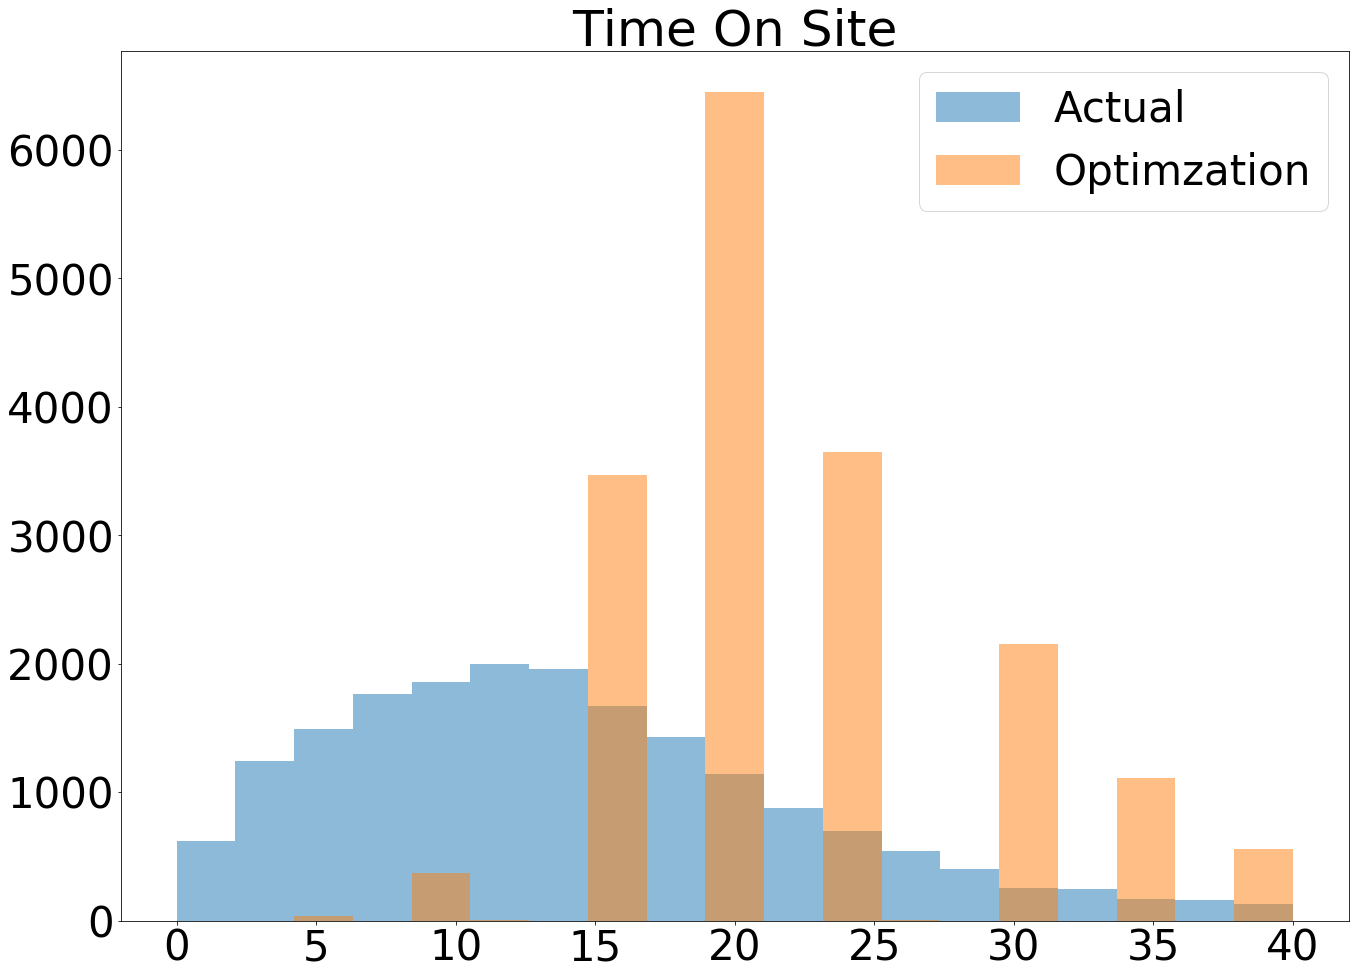

In [28]:
from matplotlib import pyplot
bins = np.linspace(0, 40, 20)
pyplot.hist(df.act_tos, bins, alpha=0.5, label='Actual')
pyplot.hist(df.opt_tos, bins, alpha=0.5, label='Optimzation')
pyplot.legend(loc='upper right')
pyplot.title('Time On Site')
pyplot.rcParams["figure.figsize"] = (15,16)
pyplot.rcParams.update({'font.size': 42})
pyplot.show()

In [15]:
df.columns

Index(['inv_count', 'run_id', 'opt_order', 'driver', 'team', 'inventory_etos',
       'tos', 'calc_tos', 'opt_in', 'opt_out', 'act_in', 'act_out', 'cat_1',
       'cat_2', 'is_late', 'cat_3', 'name', 'type', 'inv_dropoff', 'h',
       'diff_in', 'diff_out', 'diff_onsite', 'opt_tos', 'act_tos'],
      dtype='object')

In [16]:
colomns_before = ['inv_count', 'inv_dropoff', 'opt_tos']
colomns_after  = ['inv_count', 'inv_dropoff', 'inventory_etos', 'opt_tos', 'h', 'driver', 'team']

#Create X and Y tables
Y = df.loc[:,['act_tos']].values.ravel()
X = df.loc[:,colomns_after]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

x_train_before = x_train[colomns_before]
x_test_before = x_test[colomns_before]

In [17]:
MSE_Bringg = getMSE(y_test, x_test.opt_tos)
print('MSE Error of the current opti estimate: ' + str(round(MSE_Bringg)))

MSE Error of the current opti estimate: 234.0


In [18]:
lm = linear_model.LinearRegression()
lm_model_before = lm.fit(x_train_before, y_train)
print ('With data before optimization \nLM Score:' + str(round(lm_model_before.score(x_test_before, y_test), 2)))

rf = RandomForestRegressor(n_estimators = 70, random_state = 42)
rf_model_before = rf.fit(x_train_before, y_train)
print ('RF Score:' + str(round(rf_model_before.score(x_test_before, y_test), 2)))

#Here we use the Linear Model as it typicallly provides better results on the simple data
MSE_Model_before = getMSE(y_test, rf_model_before.predict(x_test_before))
print('MSE Error of the model with data BEFORE optimization: ' + str(round(MSE_Model_before)) + " = " + 
                                    str(round(100 - 100 * MSE_Model_before/ MSE_Bringg)) + r'% Reduction')

With data before optimization 
LM Score:0.06
RF Score:0.09
MSE Error of the model with data BEFORE optimization: 87.0 = 63.0% Reduction


In [19]:
lm = linear_model.LinearRegression()
lm_model_after = lm.fit(x_train, y_train)
print ('LM Score:' + str(round(lm_model_after.score(x_test, y_test), 2)))

rf = RandomForestRegressor(n_estimators = 95, random_state = 42)
rf_model_after = rf.fit(x_train, y_train)
print ('RF Score:' + str(round(rf_model_after.score(x_test, y_test), 2)))

# After the optimization the Random Forest provides better results
MSE_Model_after = getMSE(y_test, lm_model_after.predict(x_test))
print('MSE Error of the model with data AFTER optimization: ' + str(round(MSE_Model_after)) + " = " + 
                                    str(round(100 - 100 * MSE_Model_after / MSE_Bringg)) + r'% Reduction')

LM Score:0.07
RF Score:-0.03
MSE Error of the model with data AFTER optimization: 89.0 = 62.0% Reduction


## Summary of the Mean Squared Error of the planned VS actual on the Testing set using the two models - bebore and after the opitimization

In [20]:
df['pred_before'] = lm_model_before.predict(df[colomns_before])
df['pred_after']  = lm_model_after.predict(df[colomns_after])

In [21]:
df.to_excel(writer,'tasks_after')

## Now lets see how the results look like. 
### What category items are being late?
### Where our estimates are not good enough?

In [22]:
df.columns

Index(['inv_count', 'run_id', 'opt_order', 'driver', 'team', 'inventory_etos',
       'tos', 'calc_tos', 'opt_in', 'opt_out', 'act_in', 'act_out', 'cat_1',
       'cat_2', 'is_late', 'cat_3', 'name', 'type', 'inv_dropoff', 'h',
       'diff_in', 'diff_out', 'diff_onsite', 'opt_tos', 'act_tos',
       'pred_before', 'pred_after'],
      dtype='object')

In [23]:
groups = df.groupby('inv_dropoff')
df_by_inventory = pd.DataFrame({'inv_count': groups.size(), 'name': groups.name.min(), 'late':groups.is_late.sum(),
                                'act_tos': groups.act_tos.mean(), 'opt_tos': groups.opt_tos.mean(),
                       'pred_before': groups.pred_before.mean(), 'pred_after': groups.pred_after.mean()})

df_by_inventory['err_percent_bringg'] = round(100 * abs(df_by_inventory['opt_tos'] - df_by_inventory['act_tos']) 
                                              / df_by_inventory['act_tos'])
df_by_inventory['err_percent_pred'] = round(100 * abs(df_by_inventory['pred_after'] - df_by_inventory['act_tos']) 
                                            / df_by_inventory['act_tos'])
df_by_inventory['improve_percent'] = df_by_inventory['err_percent_pred'] - df_by_inventory['err_percent_bringg'] 
df_by_inventory['late_percent'] = round(100 * df_by_inventory['late'] / df_by_inventory['inv_count']) 


df_by_inventory.sort_values('improve_percent', inplace=True, ascending=True)
round(df_by_inventory[df_by_inventory.inv_count > 10])

,inv_count,name,late,act_tos,opt_tos,pred_before,pred_after,err_percent_bringg,err_percent_pred,improve_percent,late_percent
inv_dropoff,,,,,,,,,,,
54.0,66,Cuis Induc ELECTROLUX EKI64900OK ELECTROLUX,1.0,5.0,40.0,16.0,18.0,654.0,233.0,-421.0,2.0
53.0,12,Domino Induc SCHNEIDER SDI30 SCHNEIDER,1.0,6.0,30.0,16.0,14.0,436.0,158.0,-278.0,8.0
52.0,16,Forfait Livraison <300 EUR BOULANGER,1.0,8.0,32.0,16.0,15.0,327.0,95.0,-232.0,6.0
387.0,525,Armoire BEKO BRFNE214M23W BEKO CG,42.0,15.0,46.0,14.0,14.0,214.0,7.0,-207.0,8.0
22.0,23,ACC. KONIX Station de charge pour 2 mane KONIX LD,1.0,11.0,30.0,17.0,16.0,185.0,46.0,-139.0,4.0
62.5,12,Aspi Laveur KARCHER FC 5 Blanc KARCHER LD,0.0,11.0,37.0,19.0,21.0,224.0,86.0,-138.0,0.0
43.0,42,Aspi Balai FAGOR FG921 Noir FAGOR LD,1.0,14.0,35.0,17.0,17.0,144.0,17.0,-127.0,2.0
31.0,72,Adaptateur APPLE USB-C Digital AV multip APPLE LD,7.0,13.0,35.0,16.0,19.0,160.0,38.0,-122.0,10.0
60.0,484,ACC. SONY PSVR MK4 + Cam�ra V2 + VR Worl SONY LD,33.0,13.0,32.0,15.0,16.0,146.0,25.0,-121.0,7.0


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#create model
model = Sequential()
n_cols = x_train.shape[1]

#add model layers
model.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))

#compile model using mse as a measure of model performance
model.compile(optimizer='adam', loss='mean_squared_error')
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=8)
#train model
model.fit(x_train, y_train, validation_split=0.2, epochs=30, callbacks=[early_stopping_monitor])

Using TensorFlow backend.


Train on 12255 samples, validate on 3064 samples
Epoch 1/30
12255/12255 [==============================] - 1s 57us/step - loss: 214.4721 - val_loss: 184.4374
Epoch 2/30
12255/12255 [==============================] - 0s 36us/step - loss: 108.6046 - val_loss: 103.7265
Epoch 3/30
12255/12255 [==============================] - 0s 36us/step - loss: 97.9502 - val_loss: 100.3021
Epoch 4/30
12255/12255 [==============================] - 0s 38us/step - loss: 92.0518 - val_loss: 139.0597
Epoch 5/30
12255/12255 [==============================] - 0s 36us/step - loss: 92.8590 - val_loss: 92.8069
Epoch 6/30
12255/12255 [==============================] - 0s 36us/step - loss: 91.2440 - val_loss: 93.6185
Epoch 7/30
12255/12255 [==============================] - 0s 36us/step - loss: 88.0870 - val_loss: 93.6743
Epoch 8/30
12255/12255 [==============================] - 0s 38us/step - loss: 89.1568 - val_loss: 93.6927
Epoch 9/30
12255/12255 [==============================] - 0s 38us/step - loss: 89.0388 - 

In [25]:
from sklearn.externals import joblib
joblib.dump(rf, r'TOS_Serivce/rf_model_before.joblib') 

['TOS_Serivce/rf_model_before.joblib']

In [26]:
df_by_inventory.to_excel(writer,'perInventory')
writer.save()
writer.close()